In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 150 # Number of epochs the model(s) are trained on
LR = 1e-5 # Learning rate the Adam optimizers use, to modify the model weights at every epoch
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming a square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation

dataset_no_sub = data.LensingDataset('../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


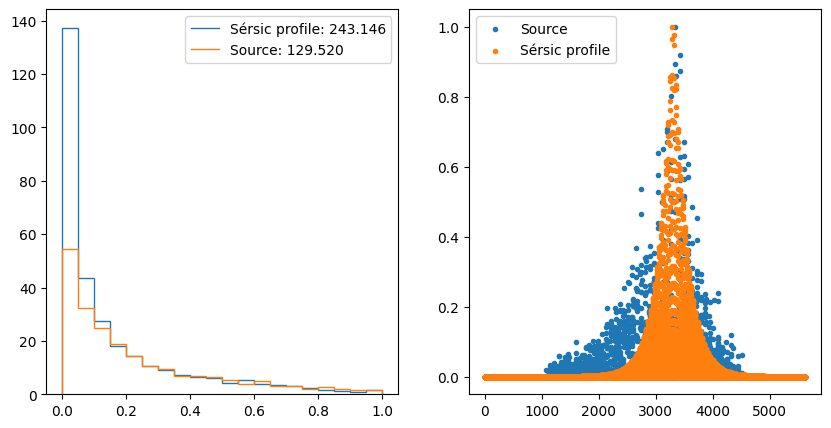

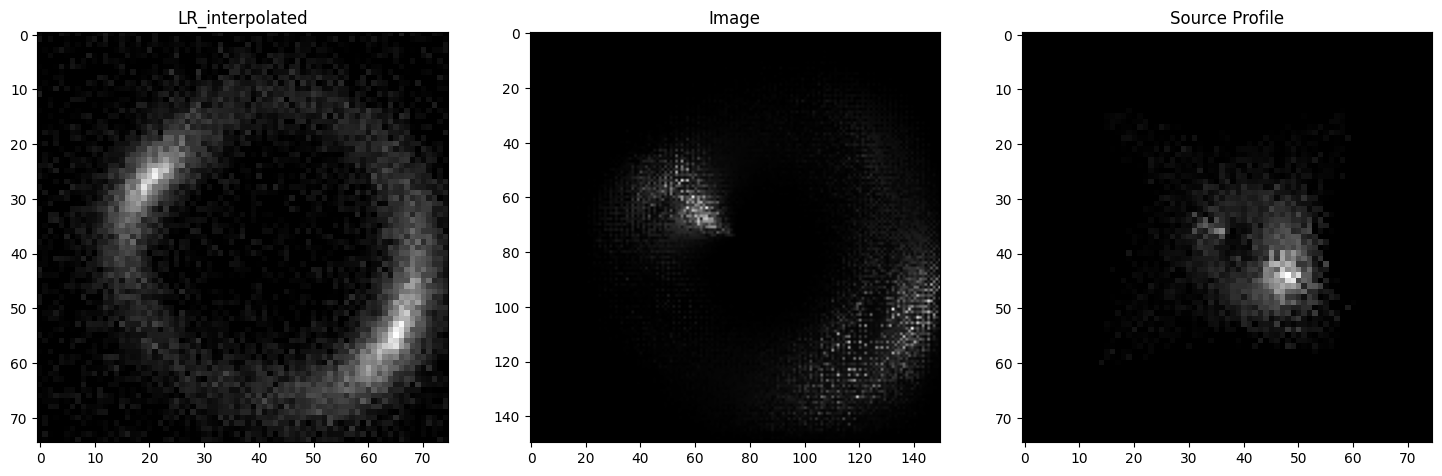

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [00:44<00:00, 18.30it/s]


Training at epoch 1/150: 0.04032413830852831 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:04<00:00, 44.14it/s]


Validation at epoch 1/150: 0.039349238059538244 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [00:44<00:00, 18.23it/s]


Training at epoch 2/150: 0.038635768142401 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:04<00:00, 43.90it/s]


Validation at epoch 2/150: 0.03757772244987827 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [00:44<00:00, 18.18it/s]


Training at epoch 3/150: 0.03643106276571166 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:04<00:00, 43.34it/s]


Validation at epoch 3/150: 0.03426066198039288 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 4/150: 0.032642085150833805 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:04<00:00, 43.42it/s]


Validation at epoch 4/150: 0.03174117731624374 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [00:45<00:00, 18.02it/s]


Training at epoch 5/150: 0.02975055751135098 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:04<00:00, 43.46it/s]


Validation at epoch 5/150: 0.030166304487661985 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [00:45<00:00, 17.99it/s]


Training at epoch 6/150: 0.02828850833854328 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:04<00:00, 43.53it/s]


Validation at epoch 6/150: 0.028430057388237298 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [00:45<00:00, 17.96it/s]


Training at epoch 7/150: 0.028101460396440004 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:04<00:00, 43.24it/s]


Validation at epoch 7/150: 0.028112313141772417 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [00:45<00:00, 17.99it/s]


Training at epoch 8/150: 0.02767908271469459 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:04<00:00, 43.21it/s]


Validation at epoch 8/150: 0.02702433574435703 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [00:45<00:00, 17.92it/s]


Training at epoch 9/150: 0.027127697680649966 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:04<00:00, 43.17it/s]


Validation at epoch 9/150: 0.027441418402447078 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [00:45<00:00, 17.98it/s]


Training at epoch 10/150: 0.0266551000386957 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:04<00:00, 42.94it/s]


Validation at epoch 10/150: 0.026100734612203035 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 11/150: 0.02603167016389618 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:04<00:00, 43.81it/s]


Validation at epoch 11/150: 0.02474578305461083 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 12/150: 0.025463554564838627 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:04<00:00, 42.64it/s]


Validation at epoch 12/150: 0.024956262522539643 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 13/150: 0.025237297277008266 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:04<00:00, 43.48it/s]


Validation at epoch 13/150: 0.02513166984794354 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 14/150: 0.024993869147359488 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:04<00:00, 42.68it/s]


Validation at epoch 14/150: 0.024716418641665037 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 15/150: 0.02475498028687686 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:04<00:00, 43.40it/s]


Validation at epoch 15/150: 0.02471371446299644 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 16/150: 0.02455640594820909 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:04<00:00, 42.72it/s]


Validation at epoch 16/150: 0.02446570824963155 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 17/150: 0.024342342223906577 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:04<00:00, 42.66it/s]


Validation at epoch 17/150: 0.024319034123882553 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 18/150: 0.02409292799136237 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:04<00:00, 42.85it/s]


Validation at epoch 18/150: 0.024017313733124598 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 19/150: 0.023848521994352723 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:04<00:00, 43.39it/s]


Validation at epoch 19/150: 0.02389411032958842 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 20/150: 0.02362354088176976 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:04<00:00, 42.42it/s]


Validation at epoch 20/150: 0.023499145012750636 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 21/150: 0.023406183176669346 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:04<00:00, 42.77it/s]


Validation at epoch 21/150: 0.023543337807424514 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 22/150: 0.02317486502938809 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:04<00:00, 42.84it/s]


Validation at epoch 22/150: 0.02295740207616701 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [00:44<00:00, 18.20it/s]


Training at epoch 23/150: 0.02294254279727551 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:04<00:00, 43.29it/s]


Validation at epoch 23/150: 0.02307481376752263 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [00:44<00:00, 18.19it/s]


Training at epoch 24/150: 0.022702892808078835 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:04<00:00, 42.80it/s]


Validation at epoch 24/150: 0.02301257965739876 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 25/150: 0.022508864168616145 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:04<00:00, 43.72it/s]


Validation at epoch 25/150: 0.022501502373237527 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 26/150: 0.02228931051712268 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:04<00:00, 43.07it/s]


Validation at epoch 26/150: 0.022357556343961856 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 27/150: 0.022088843945971794 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:04<00:00, 43.12it/s]


Validation at epoch 27/150: 0.022090285416028314 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 28/150: 0.021890059683827012 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:04<00:00, 43.30it/s]


Validation at epoch 28/150: 0.021949367904038383 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 29/150: 0.021705823348872187 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:04<00:00, 42.42it/s]


Validation at epoch 29/150: 0.021629858418789664 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 30/150: 0.02152002393533764 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:04<00:00, 41.88it/s]


Validation at epoch 30/150: 0.02128551973888249 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 31/150: 0.02130701876126741 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:04<00:00, 42.69it/s]


Validation at epoch 31/150: 0.021234688034062 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [00:45<00:00, 18.07it/s]


Training at epoch 32/150: 0.021087930011795902 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:04<00:00, 43.70it/s]


Validation at epoch 32/150: 0.021111527914363964 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 33/150: 0.020848576431436575 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:04<00:00, 42.31it/s]


Validation at epoch 33/150: 0.02081288916844071 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 34/150: 0.020647207520418234 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:04<00:00, 42.93it/s]


Validation at epoch 34/150: 0.020622659232650026 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [00:45<00:00, 18.04it/s]


Training at epoch 35/150: 0.02047654394489512 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:04<00:00, 42.39it/s]


Validation at epoch 35/150: 0.020562606735848914 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 36/150: 0.020263790489252642 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:04<00:00, 42.60it/s]


Validation at epoch 36/150: 0.020435724263297386 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 37/150: 0.020013800694149673 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:04<00:00, 42.93it/s]


Validation at epoch 37/150: 0.02003928241969463 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 38/150: 0.01983366449085046 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:04<00:00, 42.74it/s]


Validation at epoch 38/150: 0.020127191751574475 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 39/150: 0.019623758846886205 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:04<00:00, 42.56it/s]


Validation at epoch 39/150: 0.019775789678461997 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 40/150: 0.019419933175385876 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:04<00:00, 43.16it/s]


Validation at epoch 40/150: 0.01940920672096385 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 41/150: 0.019238682496007624 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:04<00:00, 42.20it/s]


Validation at epoch 41/150: 0.01931207530730057 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [00:44<00:00, 18.19it/s]


Training at epoch 42/150: 0.019043268582226672 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:04<00:00, 42.28it/s]


Validation at epoch 42/150: 0.019062059904065204 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 43/150: 0.01879498928753367 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:04<00:00, 42.73it/s]


Validation at epoch 43/150: 0.018852666253224015 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 44/150: 0.018558588679094972 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:04<00:00, 42.82it/s]


Validation at epoch 44/150: 0.018655766376896817 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 45/150: 0.018340478465266086 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:04<00:00, 42.61it/s]


Validation at epoch 45/150: 0.018368891225762518 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 46/150: 0.018147811268492804 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:04<00:00, 42.23it/s]


Validation at epoch 46/150: 0.01810981945919932 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 47/150: 0.01792701967996454 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:04<00:00, 42.68it/s]


Validation at epoch 47/150: 0.01788565811847209 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 48/150: 0.017711622558315012 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:04<00:00, 42.83it/s]


Validation at epoch 48/150: 0.017640381941900533 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [00:44<00:00, 18.17it/s]


Training at epoch 49/150: 0.017509776748506827 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:04<00:00, 42.46it/s]


Validation at epoch 49/150: 0.01746423502324843 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 50/150: 0.01730570011069158 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:04<00:00, 43.46it/s]


Validation at epoch 50/150: 0.017289689527459295 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 51/150: 0.01701800237459989 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:04<00:00, 42.23it/s]


Validation at epoch 51/150: 0.017100429011727956 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 52/150: 0.01675418955639151 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:04<00:00, 43.25it/s]


Validation at epoch 52/150: 0.016628142391495845 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 53/150: 0.016499548325287727 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:04<00:00, 42.75it/s]


Validation at epoch 53/150: 0.0166381067075931 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [00:45<00:00, 18.00it/s]


Training at epoch 54/150: 0.016249509191587932 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:04<00:00, 41.87it/s]


Validation at epoch 54/150: 0.016181966997500435 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [00:44<00:00, 18.22it/s]


Training at epoch 55/150: 0.016001030439410365 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:04<00:00, 42.71it/s]


Validation at epoch 55/150: 0.016174595099965147 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 56/150: 0.015752784875843417 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:04<00:00, 42.92it/s]


Validation at epoch 56/150: 0.015693925371320517 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [00:45<00:00, 18.03it/s]


Training at epoch 57/150: 0.015474415092053367 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:04<00:00, 42.79it/s]


Validation at epoch 57/150: 0.015507547435916815 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 58/150: 0.015195915986267065 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:04<00:00, 42.35it/s]


Validation at epoch 58/150: 0.015306596995751355 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 59/150: 0.014947794053658108 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:04<00:00, 43.11it/s]


Validation at epoch 59/150: 0.014912732648571916 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 60/150: 0.01471642819666943 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:04<00:00, 42.95it/s]


Validation at epoch 60/150: 0.014851643210824798 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 61/150: 0.014481417192762499 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:04<00:00, 42.65it/s]


Validation at epoch 61/150: 0.014742828745796693 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 62/150: 0.014214321352340574 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:04<00:00, 41.97it/s]


Validation at epoch 62/150: 0.01440717838704586 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 63/150: 0.013936991286514325 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:04<00:00, 42.86it/s]


Validation at epoch 63/150: 0.013901547597282949 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 64/150: 0.01365610570701838 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:04<00:00, 42.67it/s]


Validation at epoch 64/150: 0.013913055334021063 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [00:45<00:00, 18.07it/s]


Training at epoch 65/150: 0.013410379213632504 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:04<00:00, 42.90it/s]


Validation at epoch 65/150: 0.013538266299292445 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [00:45<00:00, 18.04it/s]


Training at epoch 66/150: 0.013165022689374346 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:04<00:00, 42.70it/s]


Validation at epoch 66/150: 0.0133985319887014 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 67/150: 0.012925673344094927 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:04<00:00, 42.85it/s]


Validation at epoch 67/150: 0.013051254925884161 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 68/150: 0.012671643984504044 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:04<00:00, 42.89it/s]


Validation at epoch 68/150: 0.012866443185153984 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 69/150: 0.01242706447259943 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:04<00:00, 43.20it/s]


Validation at epoch 69/150: 0.012892932206501855 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 70/150: 0.012200198968867863 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:04<00:00, 42.57it/s]


Validation at epoch 70/150: 0.01242266709952816 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 71/150: 0.011973396282615689 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:04<00:00, 43.30it/s]


Validation at epoch 71/150: 0.012447658577002585 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 72/150: 0.011778186680863192 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:04<00:00, 43.15it/s]


Validation at epoch 72/150: 0.011854906299370615 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 73/150: 0.011555209471707177 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:04<00:00, 43.31it/s]


Validation at epoch 73/150: 0.011706687850128933 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 74/150: 0.01132224891947923 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:04<00:00, 43.49it/s]


Validation at epoch 74/150: 0.011393471771632047 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [00:45<00:00, 18.03it/s]


Training at epoch 75/150: 0.01108063833907199 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:04<00:00, 43.49it/s]


Validation at epoch 75/150: 0.01104724743887417 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [00:44<00:00, 18.17it/s]


Training at epoch 76/150: 0.010815695215783575 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:04<00:00, 42.41it/s]


Validation at epoch 76/150: 0.01097037985592204 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 77/150: 0.010572885184858166 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:04<00:00, 42.78it/s]


Validation at epoch 77/150: 0.010584925271698511 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 78/150: 0.010341877414497967 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:04<00:00, 42.78it/s]


Validation at epoch 78/150: 0.010488827550765491 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 79/150: 0.010108153790568787 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:04<00:00, 43.22it/s]


Validation at epoch 79/150: 0.010352988738804032 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [00:44<00:00, 18.17it/s]


Training at epoch 80/150: 0.009880299231964255 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:04<00:00, 42.32it/s]


Validation at epoch 80/150: 0.00993388518006267 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [00:44<00:00, 18.17it/s]


Training at epoch 81/150: 0.009649366922745043 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:04<00:00, 43.04it/s]


Validation at epoch 81/150: 0.009681636579426042 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 82/150: 0.009410460880733844 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:04<00:00, 41.98it/s]


Validation at epoch 82/150: 0.009698698379318504 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 83/150: 0.009175282014492789 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:04<00:00, 43.09it/s]


Validation at epoch 83/150: 0.009621325775287022 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [00:45<00:00, 18.07it/s]


Training at epoch 84/150: 0.008945430974206687 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:04<00:00, 42.21it/s]


Validation at epoch 84/150: 0.009339490261695841 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 85/150: 0.008743582448611656 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:04<00:00, 42.87it/s]


Validation at epoch 85/150: 0.008854791252672965 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 86/150: 0.008511361147861416 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:04<00:00, 42.81it/s]


Validation at epoch 86/150: 0.008601610822712673 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [00:45<00:00, 18.02it/s]


Training at epoch 87/150: 0.008277451481976016 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:04<00:00, 42.65it/s]


Validation at epoch 87/150: 0.008216597776695648 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [00:45<00:00, 18.02it/s]


Training at epoch 88/150: 0.008073737823710247 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:04<00:00, 42.38it/s]


Validation at epoch 88/150: 0.008144301942129638 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 89/150: 0.007867974016299545 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:04<00:00, 42.65it/s]


Validation at epoch 89/150: 0.00817367761149345 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 90/150: 0.007652358450999886 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:04<00:00, 42.74it/s]


Validation at epoch 90/150: 0.007807574625236585 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [00:45<00:00, 17.99it/s]


Training at epoch 91/150: 0.00746115111099903 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:04<00:00, 41.99it/s]


Validation at epoch 91/150: 0.007559028440429007 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 92/150: 0.0072956590430454955 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:04<00:00, 42.68it/s]


Validation at epoch 92/150: 0.007550966971572123 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 93/150: 0.007111877841559951 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:04<00:00, 42.40it/s]


Validation at epoch 93/150: 0.007107901171205894 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [00:45<00:00, 18.02it/s]


Training at epoch 94/150: 0.00694158614051583 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:04<00:00, 42.82it/s]


Validation at epoch 94/150: 0.0070468013736364596 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 95/150: 0.006780489621793523 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:04<00:00, 43.32it/s]


Validation at epoch 95/150: 0.006776855577139512 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [00:45<00:00, 18.01it/s]


Training at epoch 96/150: 0.006619318704264622 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:04<00:00, 42.87it/s]


Validation at epoch 96/150: 0.006726227119775014 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 97/150: 0.006442888338271729 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:04<00:00, 42.99it/s]


Validation at epoch 97/150: 0.006494545293332753 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [00:45<00:00, 18.04it/s]


Training at epoch 98/150: 0.0062946915374292685 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:04<00:00, 42.76it/s]


Validation at epoch 98/150: 0.0063582584033628885 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 99/150: 0.006141466654976373 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:04<00:00, 43.57it/s]


Validation at epoch 99/150: 0.006130249080859928 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [00:44<00:00, 18.18it/s]


Training at epoch 100/150: 0.006003201527690572 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:04<00:00, 42.78it/s]


Validation at epoch 100/150: 0.006216234796881384 at LR=1e-05


Training epoch 101: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 101/150: 0.005867078845018541 at LR=1e-05


Validation epoch 101: 100%|██████████| 204/204 [00:04<00:00, 42.16it/s]


Validation at epoch 101/150: 0.005867763429277521 at LR=1e-05


Training epoch 102: 100%|██████████| 816/816 [00:45<00:00, 17.98it/s]


Training at epoch 102/150: 0.005733192439408287 at LR=1e-05


Validation epoch 102: 100%|██████████| 204/204 [00:04<00:00, 42.90it/s]


Validation at epoch 102/150: 0.005817320746798799 at LR=1e-05


Training epoch 103: 100%|██████████| 816/816 [00:45<00:00, 18.01it/s]


Training at epoch 103/150: 0.005609323881701272 at LR=1e-05


Validation epoch 103: 100%|██████████| 204/204 [00:04<00:00, 41.91it/s]


Validation at epoch 103/150: 0.0057292588536773685 at LR=1e-05


Training epoch 104: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 104/150: 0.005495248012034697 at LR=1e-05


Validation epoch 104: 100%|██████████| 204/204 [00:04<00:00, 42.92it/s]


Validation at epoch 104/150: 0.005578640301702726 at LR=1e-05


Training epoch 105: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 105/150: 0.005386358763572906 at LR=1e-05


Validation epoch 105: 100%|██████████| 204/204 [00:04<00:00, 43.05it/s]


Validation at epoch 105/150: 0.005468976714730482 at LR=1e-05


Training epoch 106: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 106/150: 0.005252895229062357 at LR=1e-05


Validation epoch 106: 100%|██████████| 204/204 [00:04<00:00, 42.79it/s]


Validation at epoch 106/150: 0.005400474260871609 at LR=1e-05


Training epoch 107: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 107/150: 0.005129508819093234 at LR=1e-05


Validation epoch 107: 100%|██████████| 204/204 [00:04<00:00, 42.25it/s]


Validation at epoch 107/150: 0.0052795138292233736 at LR=1e-05


Training epoch 108: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 108/150: 0.005029610667478147 at LR=1e-05


Validation epoch 108: 100%|██████████| 204/204 [00:04<00:00, 42.85it/s]


Validation at epoch 108/150: 0.004922432369579945 at LR=1e-05


Training epoch 109: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 109/150: 0.004934434449430281 at LR=1e-05


Validation epoch 109: 100%|██████████| 204/204 [00:04<00:00, 42.80it/s]


Validation at epoch 109/150: 0.004937692204097688 at LR=1e-05


Training epoch 110: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 110/150: 0.004872831592722065 at LR=1e-05


Validation epoch 110: 100%|██████████| 204/204 [00:04<00:00, 42.75it/s]


Validation at epoch 110/150: 0.004798627392315835 at LR=1e-05


Training epoch 111: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 111/150: 0.004833639025580887 at LR=1e-05


Validation epoch 111: 100%|██████████| 204/204 [00:04<00:00, 43.07it/s]


Validation at epoch 111/150: 0.004804346875935866 at LR=1e-05


Training epoch 112: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 112/150: 0.0047964988297476965 at LR=1e-05


Validation epoch 112: 100%|██████████| 204/204 [00:04<00:00, 42.25it/s]


Validation at epoch 112/150: 0.004781634468064808 at LR=1e-05


Training epoch 113: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 113/150: 0.004754474641944684 at LR=1e-05


Validation epoch 113: 100%|██████████| 204/204 [00:04<00:00, 42.81it/s]


Validation at epoch 113/150: 0.004679920999835446 at LR=1e-05


Training epoch 114: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 114/150: 0.0047155266862211965 at LR=1e-05


Validation epoch 114: 100%|██████████| 204/204 [00:04<00:00, 43.15it/s]


Validation at epoch 114/150: 0.00462538039302636 at LR=1e-05


Training epoch 115: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 115/150: 0.004695772401093706 at LR=1e-05


Validation epoch 115: 100%|██████████| 204/204 [00:04<00:00, 42.83it/s]


Validation at epoch 115/150: 0.004601283780728266 at LR=1e-05


Training epoch 116: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 116/150: 0.004662247008858614 at LR=1e-05


Validation epoch 116: 100%|██████████| 204/204 [00:04<00:00, 42.17it/s]


Validation at epoch 116/150: 0.004588887177626877 at LR=1e-05


Training epoch 117: 100%|██████████| 816/816 [00:45<00:00, 17.99it/s]


Training at epoch 117/150: 0.004651288098744664 at LR=1e-05


Validation epoch 117: 100%|██████████| 204/204 [00:04<00:00, 42.89it/s]


Validation at epoch 117/150: 0.0045845299575696975 at LR=1e-05


Training epoch 118: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 118/150: 0.0046407626108631635 at LR=1e-05


Validation epoch 118: 100%|██████████| 204/204 [00:04<00:00, 43.27it/s]


Validation at epoch 118/150: 0.004587311481408702 at LR=1e-05


Training epoch 119: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 119/150: 0.004609899891839435 at LR=1e-05


Validation epoch 119: 100%|██████████| 204/204 [00:04<00:00, 43.68it/s]


Validation at epoch 119/150: 0.004589079285734424 at LR=1e-05


Training epoch 120: 100%|██████████| 816/816 [00:44<00:00, 18.17it/s]


Training at epoch 120/150: 0.004601629453199897 at LR=1e-05


Validation epoch 120: 100%|██████████| 204/204 [00:04<00:00, 42.97it/s]


Validation at epoch 120/150: 0.00457804008414421 at LR=1e-05


Training epoch 121: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 121/150: 0.004587453735510672 at LR=1e-05


Validation epoch 121: 100%|██████████| 204/204 [00:04<00:00, 42.53it/s]


Validation at epoch 121/150: 0.004538147849505585 at LR=1e-05


Training epoch 122: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 122/150: 0.0045894702742967355 at LR=1e-05


Validation epoch 122: 100%|██████████| 204/204 [00:04<00:00, 42.60it/s]


Validation at epoch 122/150: 0.004541930855553159 at LR=1e-05


Training epoch 123: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 123/150: 0.00458327225265641 at LR=1e-05


Validation epoch 123: 100%|██████████| 204/204 [00:04<00:00, 42.86it/s]


Validation at epoch 123/150: 0.004542881729053881 at LR=1e-05


Training epoch 124: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 124/150: 0.004586903184056556 at LR=1e-05


Validation epoch 124: 100%|██████████| 204/204 [00:04<00:00, 43.06it/s]


Validation at epoch 124/150: 0.004548074572584501 at LR=1e-05


Training epoch 125: 100%|██████████| 816/816 [00:45<00:00, 18.13it/s]


Training at epoch 125/150: 0.004591557720000399 at LR=1e-05


Validation epoch 125: 100%|██████████| 204/204 [00:04<00:00, 42.54it/s]


Validation at epoch 125/150: 0.004555275376119158 at LR=1e-05


Training epoch 126: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 126/150: 0.00457589044355486 at LR=1e-05


Validation epoch 126: 100%|██████████| 204/204 [00:04<00:00, 42.10it/s]


Validation at epoch 126/150: 0.004561422727134663 at LR=1e-05


Training epoch 127: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 127/150: 0.004579101909721252 at LR=1e-05


Validation epoch 127: 100%|██████████| 204/204 [00:04<00:00, 42.77it/s]


Validation at epoch 127/150: 0.004569592766975071 at LR=1e-05


Training epoch 128: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 128/150: 0.004588244865504641 at LR=1e-05


Validation epoch 128: 100%|██████████| 204/204 [00:04<00:00, 42.56it/s]


Validation at epoch 128/150: 0.004646157997651208 at LR=1e-05


Training epoch 129: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 129/150: 0.0045896975326981835 at LR=1e-05


Validation epoch 129: 100%|██████████| 204/204 [00:04<00:00, 42.67it/s]


Validation at epoch 129/150: 0.004562640983803088 at LR=1e-05


Training epoch 130: 100%|██████████| 816/816 [00:45<00:00, 18.02it/s]


Training at epoch 130/150: 0.004591261327161691 at LR=1e-05


Validation epoch 130: 100%|██████████| 204/204 [00:04<00:00, 42.75it/s]


Validation at epoch 130/150: 0.004555903757493212 at LR=1e-05


Training epoch 131: 100%|██████████| 816/816 [00:45<00:00, 18.06it/s]


Training at epoch 131/150: 0.0045919370533346075 at LR=1e-05


Validation epoch 131: 100%|██████████| 204/204 [00:04<00:00, 42.34it/s]


Validation at epoch 131/150: 0.004556973388318119 at LR=1e-05


Training epoch 132: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 132/150: 0.00459131912765431 at LR=1e-05


Validation epoch 132: 100%|██████████| 204/204 [00:04<00:00, 42.86it/s]


Validation at epoch 132/150: 0.004546378019001043 at LR=1e-05


Training epoch 133: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 133/150: 0.004591920305221506 at LR=1e-05


Validation epoch 133: 100%|██████████| 204/204 [00:04<00:00, 43.43it/s]


Validation at epoch 133/150: 0.004635361850709088 at LR=1e-05


Training epoch 134: 100%|██████████| 816/816 [00:45<00:00, 18.01it/s]


Training at epoch 134/150: 0.00459156052880537 at LR=1e-05


Validation epoch 134: 100%|██████████| 204/204 [00:04<00:00, 42.47it/s]


Validation at epoch 134/150: 0.00463412597652196 at LR=1e-05


Training epoch 135: 100%|██████████| 816/816 [00:45<00:00, 18.10it/s]


Training at epoch 135/150: 0.00459026446846752 at LR=1e-05


Validation epoch 135: 100%|██████████| 204/204 [00:04<00:00, 42.59it/s]


Validation at epoch 135/150: 0.004571578503065907 at LR=1e-05


Training epoch 136: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 136/150: 0.0045913909850117075 at LR=1e-05


Validation epoch 136: 100%|██████████| 204/204 [00:04<00:00, 42.26it/s]


Validation at epoch 136/150: 0.004601964689380325 at LR=1e-05


Training epoch 137: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 137/150: 0.004590178250367114 at LR=1e-05


Validation epoch 137: 100%|██████████| 204/204 [00:04<00:00, 43.19it/s]


Validation at epoch 137/150: 0.0045625829884289384 at LR=1e-05


Training epoch 138: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 138/150: 0.0045916158802962554 at LR=1e-05


Validation epoch 138: 100%|██████████| 204/204 [00:04<00:00, 42.32it/s]


Validation at epoch 138/150: 0.004583723566896629 at LR=1e-05


Training epoch 139: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 139/150: 0.004591504331591411 at LR=1e-05


Validation epoch 139: 100%|██████████| 204/204 [00:04<00:00, 42.45it/s]


Validation at epoch 139/150: 0.004610085969462115 at LR=1e-05


Training epoch 140: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 140/150: 0.004590428867160489 at LR=1e-05


Validation epoch 140: 100%|██████████| 204/204 [00:04<00:00, 43.19it/s]


Validation at epoch 140/150: 0.004569481814042756 at LR=1e-05


Training epoch 141: 100%|██████████| 816/816 [00:44<00:00, 18.15it/s]


Training at epoch 141/150: 0.004589518009999986 at LR=1e-05


Validation epoch 141: 100%|██████████| 204/204 [00:04<00:00, 41.90it/s]


Validation at epoch 141/150: 0.004645498390720391 at LR=1e-05


Training epoch 142: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 142/150: 0.004591669477853358 at LR=1e-05


Validation epoch 142: 100%|██████████| 204/204 [00:04<00:00, 43.09it/s]


Validation at epoch 142/150: 0.004583631135413752 at LR=1e-05


Training epoch 143: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 143/150: 0.00459113596440932 at LR=1e-05


Validation epoch 143: 100%|██████████| 204/204 [00:04<00:00, 42.51it/s]


Validation at epoch 143/150: 0.0045702618115362435 at LR=1e-05


Training epoch 144: 100%|██████████| 816/816 [00:45<00:00, 18.12it/s]


Training at epoch 144/150: 0.0045916189655876155 at LR=1e-05


Validation epoch 144: 100%|██████████| 204/204 [00:04<00:00, 42.29it/s]


Validation at epoch 144/150: 0.004557359162444139 at LR=1e-05


Training epoch 145: 100%|██████████| 816/816 [00:44<00:00, 18.16it/s]


Training at epoch 145/150: 0.004590647436071224 at LR=1e-05


Validation epoch 145: 100%|██████████| 204/204 [00:04<00:00, 43.10it/s]


Validation at epoch 145/150: 0.004580423711826477 at LR=1e-05


Training epoch 146: 100%|██████████| 816/816 [00:45<00:00, 18.01it/s]


Training at epoch 146/150: 0.004592477387917575 at LR=1e-05


Validation epoch 146: 100%|██████████| 204/204 [00:04<00:00, 41.78it/s]


Validation at epoch 146/150: 0.0045434247140827425 at LR=1e-05


Training epoch 147: 100%|██████████| 816/816 [00:45<00:00, 18.05it/s]


Training at epoch 147/150: 0.004590814821616125 at LR=1e-05


Validation epoch 147: 100%|██████████| 204/204 [00:04<00:00, 42.27it/s]


Validation at epoch 147/150: 0.00463586666520831 at LR=1e-05


Training epoch 148: 100%|██████████| 816/816 [00:45<00:00, 18.11it/s]


Training at epoch 148/150: 0.0045925863931759025 at LR=1e-05


Validation epoch 148: 100%|██████████| 204/204 [00:04<00:00, 42.63it/s]


Validation at epoch 148/150: 0.004542395566115338 at LR=1e-05


Training epoch 149: 100%|██████████| 816/816 [00:45<00:00, 18.08it/s]


Training at epoch 149/150: 0.004590269617562858 at LR=1e-05


Validation epoch 149: 100%|██████████| 204/204 [00:04<00:00, 42.78it/s]


Validation at epoch 149/150: 0.0045839774607242464 at LR=1e-05


Training epoch 150: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 150/150: 0.0045911755898451504 at LR=1e-05


Validation epoch 150: 100%|██████████| 204/204 [00:04<00:00, 42.94it/s]

Validation at epoch 150/150: 0.004646961070487604 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

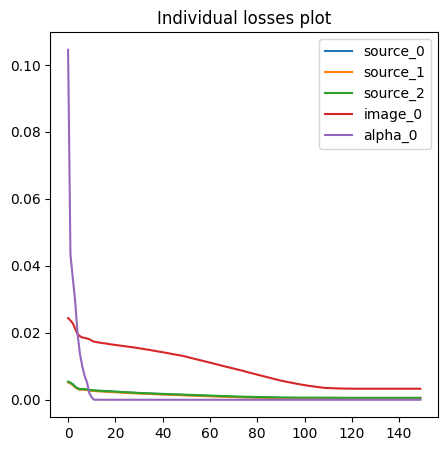

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

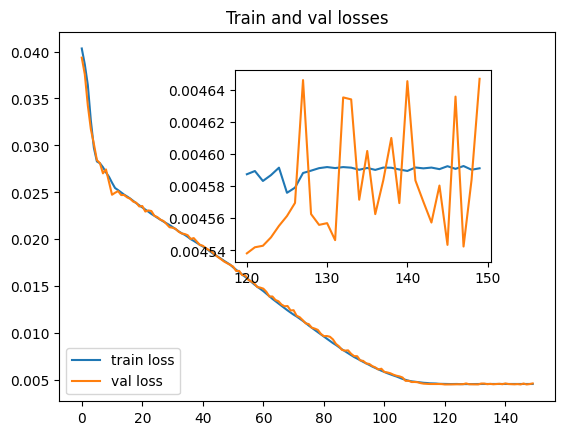

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.004538147849505585


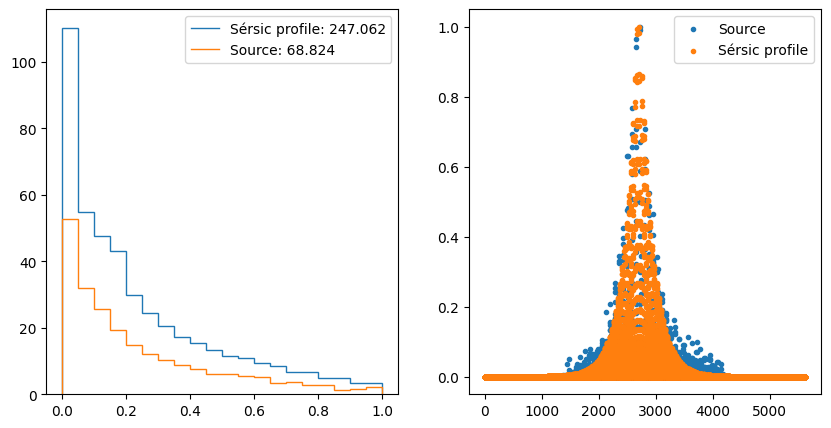

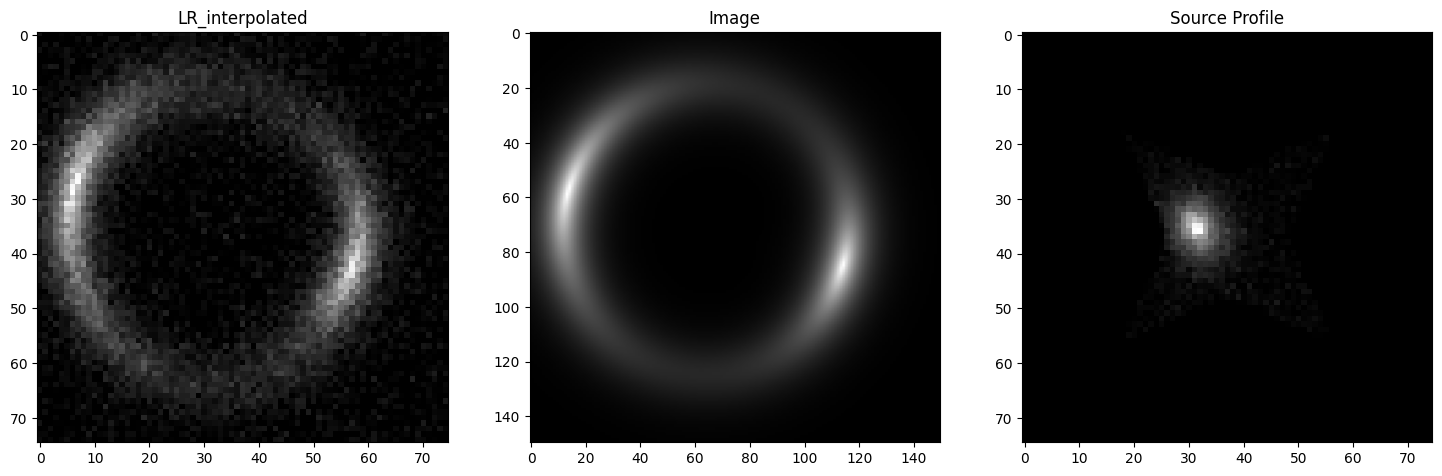

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_1.pt')